In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    predictions = torch.argmax(torch.tensor(logits), dim=1).cpu().numpy()
    labels = torch.tensor(labels).cpu().numpy()

    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, target_names=['fake', 'biased', 'true'])

    print(report)
    return {"accuracy": accuracy}

In [6]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Dataset
- split the data into training and validation sets (80% training, 20% validation) using stratified sampling
- map the labels to integers
- initialize the CamemBERT tokenizer
- create custom dataset for PyTorch

In [7]:
train_df = pd.read_csv("train.csv")

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Text'],
    train_df['Label'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['Label']
)

label_mapping = {'fake': 0, 'biased': 1, 'true': 2}
y_train = y_train.map(label_mapping)
y_val = y_val.map(label_mapping)

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

train_dataset = NewsDataset(X_train, y_train, tokenizer)
val_dataset = NewsDataset(X_val, y_val, tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Checking the class distribution
- calculate the class distribution for the training and validation sets

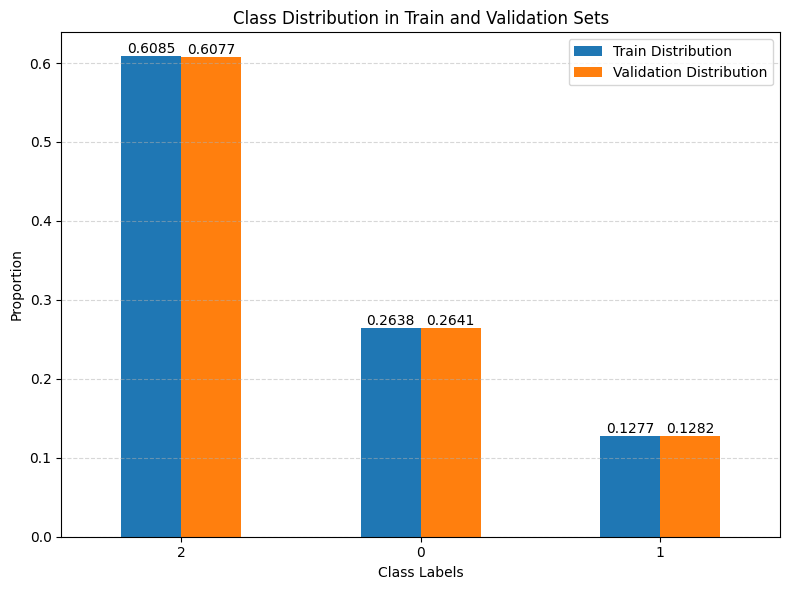

In [15]:
train_distribution = y_train.value_counts(normalize=True)
val_distribution = y_val.value_counts(normalize=True)

distribution_df = pd.DataFrame({
    'Train Distribution': train_distribution,
    'Validation Distribution': val_distribution
}).fillna(0)  

fig, ax = plt.subplots(figsize=(8, 6))

bars = distribution_df.plot(kind='bar', ax=ax)

for bar in bars.containers:
    ax.bar_label(bar, fmt='%.4f', label_type='edge')

ax.set_title('Class Distribution in Train and Validation Sets')
ax.set_xlabel('Class Labels')
ax.set_ylabel('Proportion')
ax.legend(['Train Distribution', 'Validation Distribution'])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Model training

- initialize the CamemBERT model
- configure the training
- train the model
- save the model and tokenizer
- evaluate the model

In [ ]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    no_cuda=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

output_dir = "./camembert-news-classifier"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

results = trainer.evaluate()
print(results)


## Predictions
- load the saved model and tokenizer
- load the test file
- make predictions and save them to a CSV file

In [ ]:
model_path = "./camembert-news-classifier"
tokenizer = CamembertTokenizer.from_pretrained(model_path)
model = CamembertForSequenceClassification.from_pretrained(model_path)

test_df = pd.read_csv("test.csv")

test_encodings = tokenizer(
    list(test_df['Text']),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)

reverse_label_mapping = {0: 'fake', 1: 'biased', 2: 'true'}
test_df['Label'] = predictions.numpy().tolist()
test_df['Label'] = test_df['Label'].map(reverse_label_mapping)

test_df.to_csv("test_predictions.csv", index=False)


## Prediction Label Distribution

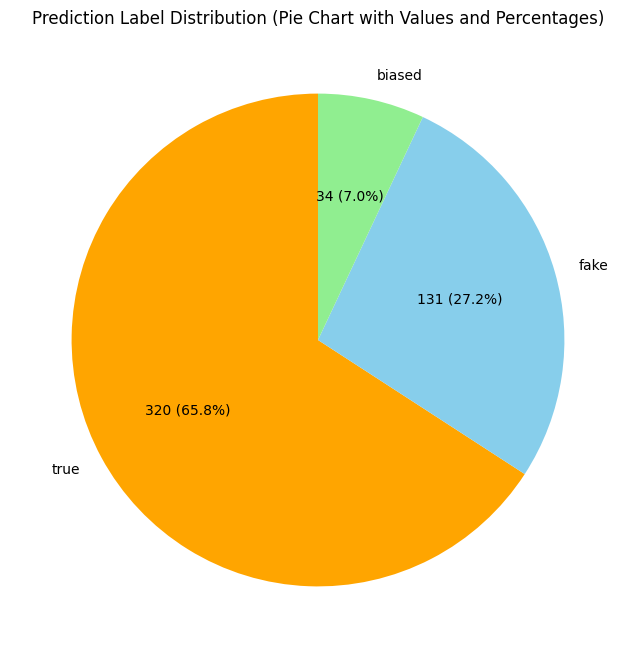

In [3]:
file_path_new_predictions = 'test_predictions.csv'
df_new_predictions = pd.read_csv(file_path_new_predictions)
new_label_counts = df_new_predictions['Label'].value_counts()

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    new_label_counts,
    labels=new_label_counts.index,
    autopct=lambda pct: f'{int(pct * new_label_counts.sum() / 100)} ({pct:.1f}%)',
    startangle=90,
    colors=['orange', 'skyblue', 'lightgreen']
)

plt.title('Prediction Label Distribution (Pie Chart with Values and Percentages)')
plt.show()
